# Expression analysis in miRNATissueAtlas

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

In [2]:
SOURCE = 'mirnatissueatlas'

In [3]:
def extract_df(string, df, handle_col_multiplicity='sum'):
	
	if string != 'all':
		new_df = df.loc[:, df.columns.str.contains(string)]
	else:
		new_df = df.copy()
	
	if handle_col_multiplicity == 'sum':
		new_df = new_df.sum(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'sum_of_expression_{string}'])
	elif handle_col_multiplicity == 'mean':
		new_df = new_df.mean(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'mean_of_expression_{string}'])
	else:
		raise ValueError("handle_col_multiplicity must be 'sum' or 'mean'")
	
	return new_df

def filter_idx(lst, df):
	# filter only those rows whose index is in the list
	new_df = df[df.index.isin(lst)]
	return new_df

def compare_expr_boxplot(df1, df2, title1, title2, plot_title, min_y, max_y, jitter=True):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.boxplot([df1.values.flatten(), df2.values.flatten()], positions=[1, 1.5], showfliers=False, medianprops={'color':'red'})

    # add jittered scatter plots
    if jitter:
        y1 = df1.values.flatten()
        y2 = df2.values.flatten()
        x1 = np.random.normal(1, 0.02, size=len(y1))  # jitter x around position 1
        x2 = np.random.normal(1.5, 0.02, size=len(y2))  # jitter x around position 2
        ax.scatter(x1, y1, color='royalblue', alpha=0.8, s=10)
        ax.scatter(x2, y2, color='orange', alpha=0.8, s=10)

    ax.grid(axis='y')
    ax.set_ylim(min_y, max_y)
    ax.set_xticklabels(['', ''])
    plt.xlim(0.7, 1.8)
    plt.tight_layout()
    plt.savefig(f"../local/pictures/expression/{SOURCE}_{plot_title}_{title1}_{title2}.png", dpi=300)
    plt.show()

    # Stats
    print(f"Data: {plot_title}")
    intro = f"Median value of sum of expression"
    print(f"{intro} {title1}: {round(np.median(df1.values.flatten()), 6)}")
    print(f"{intro} {title2}: {round(np.median(df2.values.flatten()), 6)}")
    print(f"Kolmogorov-Smirnov test:\t{ks_2samp(df1.values.flatten(), df2.values.flatten())}")
    print(f"Mann-Whitney U test:\t\t{mannwhitneyu(df1.values.flatten(), df2.values.flatten())}")

def extract_list(list_of_tuples):
	lst = []
	present = []
	
	for t in list_of_tuples:
	
		if t[0] in present:
			continue
		
		if t[1] in present:
			continue
		
		lst.append(t[0])
		lst.append(t[1])

		present.append(t[0])
		present.append(t[1])

	return lst

def handle_duplicated_rows(df, strategy):

    if strategy not in {'mean', 'max', 'min'}:
        raise ValueError("Strategy must be one of: 'mean', 'max', 'min'")

    return df.groupby(df.index).agg(strategy)

def norm_column(df):
	return df.div(df.sum(axis=0), axis=1)

_________

In [4]:
avg_expr_matrix_path = './all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

In [5]:
with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

In [6]:
avg_expr_matrix_path = './all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'
expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df

/tmp/ipykernel_19822/2160559529.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,1088.428021,243.546543,0.043313,219.914918,568.125633,194.249264,281.727338,42.597923,137.123529,565.522809,...,1485.267408,1012.027760,2450.948916,2259.509429,1271.972792,2476.532603,467.290950,1236.827140,2437.746786,776.000649
Hsa-Let-7-P1b,6.505383,4.492620,0.000000,47.933493,15.282738,2.515213,0.649421,0.401885,3.789879,3.072286,...,2.586946,5.930494,5.310115,11.823245,10.589435,4.679424,4.812450,6.962467,33.098248,4.027219
Hsa-Let-7-P1c,4.816620,0.000000,0.000000,44.683410,0.308100,12.401268,0.023610,0.000000,1.241202,1.098243,...,3.459201,5.605949,3.207017,11.017460,10.217927,4.434976,2.537118,1.827755,4.520438,1.293623
Hsa-Let-7-P1c,4765.081268,206.162963,0.557305,609.405956,87.788778,1595.478431,91.012267,197.572829,522.647640,1082.661796,...,4764.332005,2030.584158,8786.298873,2077.455856,1362.149626,8060.796190,1114.537047,2994.291358,12096.249358,2990.441585
Hsa-Let-7-P1d,0.582867,0.754825,0.000000,68.443741,0.179697,0.000000,0.000000,0.000000,0.469278,0.381515,...,0.365671,0.565189,1.068588,5.455957,2.780810,0.838106,7.392894,0.204405,1.249168,0.557457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P2,2.985072,1043.589374,6.907106,47.118951,55.192044,33.070895,151.360592,150.744449,425.107901,529.451015,...,310.940806,8656.767830,377.471680,43.859254,1297.497460,123.201543,182.363125,1748.267031,220.295288,207.660570
Hsa-Mir-96-P3,0.000000,2.507751,0.000000,35.292801,1.349744,0.206051,0.037953,0.025759,1.006019,0.453172,...,12.403298,9.526723,1.988102,0.032581,4.613867,1.466685,1.849835,0.908452,2.879971,0.497193
Hsa-Mir-96-P3,0.747757,842.679437,5.148449,36.157231,34.706521,22.573360,13.384168,96.518346,150.865892,346.188089,...,219.570064,593.713919,112.203670,4.740391,437.259549,43.511656,77.749900,174.234731,93.439187,60.275389


In [7]:
expr_df_avg = handle_duplicated_rows(expr_df, 'mean')
expr_df_avg

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,547.466702,124.019582,0.021657,133.924206,291.704185,98.382238,141.188380,21.499904,70.456704,284.297547,...,743.927177,508.979127,1228.129515,1135.666337,641.281113,1240.606013,236.051700,621.894804,1235.422517,390.013934
Hsa-Let-7-P1c,2384.948944,103.081481,0.278653,327.044683,44.048439,803.939849,45.517938,98.786414,261.944421,541.880020,...,2383.895603,1018.095053,4394.752945,1044.236658,686.183776,4032.615583,558.537082,1498.059557,6050.384898,1495.867604
Hsa-Let-7-P1d,5371.919678,1765.563904,3.266764,507.047889,1204.705255,14065.540419,7837.714163,1516.456772,1580.991433,8258.436257,...,20104.139816,14431.840738,29551.913246,7654.003527,4581.824811,14538.899543,2682.235078,9789.778836,15470.905426,7397.824723
Hsa-Let-7-P2a1,5412.119455,1791.302880,3.266764,503.575495,1242.749562,14629.048061,7845.698765,1535.964167,1597.390602,8273.277945,...,20170.486434,14492.783993,29645.287493,7675.528032,4617.664002,14603.154316,2695.520763,9811.544458,15487.586489,7419.844382
Hsa-Let-7-P2a2,5412.119455,1791.302880,3.266764,503.575495,1242.749562,14629.048061,7845.698765,1535.964167,1597.390602,8273.277945,...,20170.486434,14492.783993,29645.287493,7675.528032,4617.664002,14603.154316,2695.520763,9811.544458,15487.586489,7419.844382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,18.213549,23.770848,0.000000,49.810573,4.907014,11.063857,1.679089,23.177767,2.838304,9.631934,...,145.691115,19.323241,31.897171,0.627706,2.305543,34.344875,23.937715,5.653909,8.819852,28.689626
Hsa-Mir-96-P1,0.000000,64.345591,0.000000,41.528149,37.452716,4.742340,1.780925,7.714999,24.818732,16.191713,...,25.671109,19.008276,64.107965,0.301924,110.892109,17.774826,36.154335,17.139664,38.010722,32.451767
Hsa-Mir-96-P2,1.492536,522.816207,3.453553,42.586950,27.796394,16.655445,75.681893,75.488381,212.764980,264.812883,...,156.838587,4328.797649,189.654329,21.932415,649.570598,61.845219,91.894958,874.232008,110.292489,103.911375


In [8]:
expr_df_avg_norm = norm_column(expr_df_avg)
expr_df_avg_norm

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.003163,1.123968e-03,0.000004,0.000892,0.000736,0.000227,0.000607,0.000482,0.000453,1.066434e-03,...,0.001616,0.000954,0.002101,4.072032e-03,0.002434,0.002025,0.001746,0.001941,0.002790,0.000756
Hsa-Let-7-P1c,0.013780,9.342094e-04,0.000055,0.002177,0.000111,0.001853,0.000196,0.002214,0.001685,2.032656e-03,...,0.005180,0.001908,0.007519,3.744203e-03,0.002605,0.006582,0.004132,0.004675,0.013663,0.002899
Hsa-Let-7-P1d,0.031038,1.600100e-02,0.000643,0.003376,0.003040,0.032427,0.033694,0.033994,0.010168,3.097838e-02,...,0.043681,0.027051,0.050558,2.744410e-02,0.017392,0.023730,0.019842,0.030553,0.034935,0.014337
Hsa-Let-7-P2a1,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
Hsa-Let-7-P2a2,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,0.000105,2.154310e-04,0.000000,0.000332,0.000012,0.000026,0.000007,0.000520,0.000018,3.613053e-05,...,0.000317,0.000036,0.000055,2.250695e-06,0.000009,0.000056,0.000177,0.000018,0.000020,0.000056
Hsa-Mir-96-P1,0.000000,5.831528e-04,0.000000,0.000276,0.000095,0.000011,0.000008,0.000173,0.000160,6.073704e-05,...,0.000056,0.000036,0.000110,1.082577e-06,0.000421,0.000029,0.000267,0.000053,0.000086,0.000063
Hsa-Mir-96-P2,0.000009,4.738192e-03,0.000680,0.000284,0.000070,0.000038,0.000325,0.001692,0.001368,9.933446e-04,...,0.000341,0.008114,0.000324,7.864060e-05,0.002466,0.000101,0.000680,0.002728,0.000249,0.000201


__________________________________

In [9]:
df_to_use = expr_df_avg_norm
df_to_use

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.003163,1.123968e-03,0.000004,0.000892,0.000736,0.000227,0.000607,0.000482,0.000453,1.066434e-03,...,0.001616,0.000954,0.002101,4.072032e-03,0.002434,0.002025,0.001746,0.001941,0.002790,0.000756
Hsa-Let-7-P1c,0.013780,9.342094e-04,0.000055,0.002177,0.000111,0.001853,0.000196,0.002214,0.001685,2.032656e-03,...,0.005180,0.001908,0.007519,3.744203e-03,0.002605,0.006582,0.004132,0.004675,0.013663,0.002899
Hsa-Let-7-P1d,0.031038,1.600100e-02,0.000643,0.003376,0.003040,0.032427,0.033694,0.033994,0.010168,3.097838e-02,...,0.043681,0.027051,0.050558,2.744410e-02,0.017392,0.023730,0.019842,0.030553,0.034935,0.014337
Hsa-Let-7-P2a1,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
Hsa-Let-7-P2a2,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,0.000105,2.154310e-04,0.000000,0.000332,0.000012,0.000026,0.000007,0.000520,0.000018,3.613053e-05,...,0.000317,0.000036,0.000055,2.250695e-06,0.000009,0.000056,0.000177,0.000018,0.000020,0.000056
Hsa-Mir-96-P1,0.000000,5.831528e-04,0.000000,0.000276,0.000095,0.000011,0.000008,0.000173,0.000160,6.073704e-05,...,0.000056,0.000036,0.000110,1.082577e-06,0.000421,0.000029,0.000267,0.000053,0.000086,0.000063
Hsa-Mir-96-P2,0.000009,4.738192e-03,0.000680,0.000284,0.000070,0.000038,0.000325,0.001692,0.001368,9.933446e-04,...,0.000341,0.008114,0.000324,7.864060e-05,0.002466,0.000101,0.000680,0.002728,0.000249,0.000201


In [10]:
df_to_use_sum = df_to_use.sum(axis=1)
df_to_use_sum = pd.DataFrame(df_to_use, columns=['sum_of_expression'])
df_to_use_sum

,sum_of_expression
"Biotype,Organ_system,Tissue,Metric",
Hsa-Let-7-P1b,NaN
Hsa-Let-7-P1c,NaN
Hsa-Let-7-P1d,NaN
Hsa-Let-7-P2a1,NaN
Hsa-Let-7-P2a2,NaN
...,...
Hsa-Mir-95,NaN
Hsa-Mir-96-P1,NaN
Hsa-Mir-96-P2,NaN


In [11]:
df_to_use_avg = df_to_use.mean(axis=1)
df_to_use_avg = pd.DataFrame(df_to_use, columns=['mean_of_expression'])
df_to_use_avg

,mean_of_expression
"Biotype,Organ_system,Tissue,Metric",
Hsa-Let-7-P1b,NaN
Hsa-Let-7-P1c,NaN
Hsa-Let-7-P1d,NaN
Hsa-Let-7-P2a1,NaN
Hsa-Let-7-P2a2,NaN
...,...
Hsa-Mir-95,NaN
Hsa-Mir-96-P1,NaN
Hsa-Mir-96-P2,NaN


_________________________________________

## Parse duplicate miRNAs

In [12]:
mirna_origin_file_path = '../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[0, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

print("Test on 'Hsa-Let-7-P1d': ", mirna_lno_dict['Hsa-Let-7-P1d'][0])

pre_2R_clades = ['Bilateria', 
                'Chordata', 
                'Eumetazoa', 
                'Vertebrata', 
                'Nephrozoa', 
                'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

Test on 'Hsa-Let-7-P1d':  Bilateria


In [13]:
om_pairs_path = f'../Motif_analysis/PPI_Bifan/ohnomirna_pairs_predict_Hsa_existent.names.extended_info.flagged_WGD_host_genes.tsv'
pm_pairs_path = f'../3_retrieve_Hsa_paralogs/mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'

om_pairs_df = pd.read_csv(om_pairs_path, sep='\t', header=0)
pm_pairs_df = pd.read_csv(pm_pairs_path, sep='\t', header=None)

print("Number of pairs BEFORE 2R filtering:", pm_pairs_df.shape[0])

pm_pairs_pre2R_df = pm_pairs_df[~pm_pairs_df[0].apply(all_clades_in_pre2R) | ~pm_pairs_df[1].apply(all_clades_in_pre2R)]
pm_pairs_post2R_df = pm_pairs_df[pm_pairs_df[0].apply(all_clades_in_pre2R) & pm_pairs_df[1].apply(all_clades_in_pre2R)]

print("Number of pairs AFTER 2R filtering:", pm_pairs_pre2R_df.shape[0], "\npost2R pairs:", pm_pairs_post2R_df.shape[0])

om_pairs_intragenic_df = om_pairs_df[~om_pairs_df['host_gene_name_1'].isin(['intergenic']) & ~om_pairs_df['host_gene_name_2'].isin(['intergenic'])]
om_pairs_intergenic_df = om_pairs_df[om_pairs_df['host_gene_name_1'].isin(['intergenic']) | om_pairs_df['host_gene_name_2'].isin(['intergenic'])]

Number of pairs BEFORE 2R filtering: 2655
Number of pairs AFTER 2R filtering: 879 
post2R pairs: 1776


In [14]:
om_pairs = om_pairs_df.iloc[:, [0, 7]].values
om_pairs = [tuple(sorted(pair)) for pair in om_pairs]
om_pairs = list(set(om_pairs))
print(f"Number of om pairs: {len(om_pairs)}", file=sys.stderr)

om_pairs_intragenic = om_pairs_intragenic_df.iloc[:, [0, 7]].values
om_pairs_intragenic = [tuple(sorted(pair)) for pair in om_pairs_intragenic]
om_pairs_intragenic = list(set(om_pairs_intragenic))
print(f"Number of om pairs intragenic: {len(om_pairs_intragenic)}", file=sys.stderr)

om_pairs_intergenic = om_pairs_intergenic_df.iloc[:, [0, 7]].values
om_pairs_intergenic = [tuple(sorted(pair)) for pair in om_pairs_intergenic]
om_pairs_intergenic = list(set(om_pairs_intergenic))
print(f"Number of om pairs intergenic: {len(om_pairs_intergenic)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

pm_pairs = pm_pairs_df.iloc[:, [0, 5]].values
pm_pairs = [tuple(sorted(pair)) for pair in pm_pairs]
pm_pairs = list(set(pm_pairs))
print(f"Number of pm pairs: {len(pm_pairs)}", file=sys.stderr)

pm_pairs_pre2R = pm_pairs_pre2R_df.iloc[:, [0, 5]].values
pm_pairs_pre2R = [tuple(sorted(pair)) for pair in pm_pairs_pre2R]
pm_pairs_pre2R = list(set(pm_pairs_pre2R))
print(f"Number of pre2R pm pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_pre2R = [pair for pair in pm_pairs_pre2R if pair not in om_pairs]
print(f"Number of pre2R pm pairs after filtering out om pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_post2R = pm_pairs_post2R_df.iloc[:, [0, 5]].values
pm_pairs_post2R = [tuple(sorted(pair)) for pair in pm_pairs_post2R]
pm_pairs_post2R = list(set(pm_pairs_post2R))
print(f"Number of post2R pm pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

pm_pairs_post2R = [pair for pair in pm_pairs_post2R if pair not in om_pairs]
print(f"Number of post2R pm pairs post2R after filtering out om pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

Number of om pairs: 114
Number of om pairs intragenic: 25
Number of om pairs intergenic: 89
Number of pm pairs: 2467
Number of pre2R pm pairs: 798
Number of pre2R pm pairs after filtering out om pairs: 783
Number of post2R pm pairs: 1669
Number of post2R pm pairs post2R after filtering out om pairs: 1570


In [15]:
om_list = extract_list(om_pairs)
pm_list = extract_list(pm_pairs)
om_list_intragenic = extract_list(om_pairs_intragenic)
om_list_intergenic = extract_list(om_pairs_intergenic)
pm_list_pre2R = extract_list(pm_pairs_pre2R)
pm_list_post2R = extract_list(pm_pairs_post2R)

# remove prom pm_list those that are in om_list
pm_list_pre2R = [m for m in pm_list_pre2R if m not in om_list]
pm_list_post2R = [m for m in pm_list_post2R if m not in om_list]
pm_list = [m for m in pm_list if m not in om_list]

for lst,l in [(om_list, 'om'), (om_list_intragenic, 'intragenic om'), (om_list_intergenic, 'intergenic om')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

for lst,l in [(pm_list, 'pm'), (pm_list_pre2R, 'pre-2R pm'), (pm_list_post2R, 'post-2R pm')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)


Number of unique om elements: 112
Number of unique intragenic om elements: 34
Number of unique intergenic om elements: 88
Number of unique pm elements: 173
Number of unique pre-2R pm elements: 80
Number of unique post-2R pm elements: 92


In [16]:
# extract a list of miRNAs that contains the string "Mir-430" (check both in om and pm)
om_list_mir430 = [m for m in om_list if 'Mir-430' in m]
pm_list_mir430 = [m for m in pm_list if 'Mir-430' in m]
mir430 = list(set(om_list_mir430).union(pm_list_mir430))

mir430

['Hsa-Mir-430-P37c',
 'Hsa-Mir-430-P37a',
 'Hsa-Mir-430-P25',
 'Hsa-Mir-430-P7',
 'Hsa-Mir-430-P18',
 'Hsa-Mir-430-P28',
 'Hsa-Mir-430-P29b',
 'Hsa-Mir-430-P31b',
 'Hsa-Mir-430-P5',
 'Hsa-Mir-430-P27',
 'Hsa-Mir-430-P40a',
 'Hsa-Mir-430-P9',
 'Hsa-Mir-430-P26',
 'Hsa-Mir-430-P4',
 'Hsa-Mir-430-P38',
 'Hsa-Mir-430-P22',
 'Hsa-Mir-430-P35',
 'Hsa-Mir-430-P15',
 'Hsa-Mir-430-P6',
 'Hsa-Mir-430-P36',
 'Hsa-Mir-430-P14',
 'Hsa-Mir-430-P37b',
 'Hsa-Mir-430-P21',
 'Hsa-Mir-430-P8a',
 'Hsa-Mir-430-P17',
 'Hsa-Mir-430-P33b',
 'Hsa-Mir-430-P8b',
 'Hsa-Mir-430-P11',
 'Hsa-Mir-430-P40b',
 'Hsa-Mir-430-P3',
 'Hsa-Mir-430-P20',
 'Hsa-Mir-430-P31a',
 'Hsa-Mir-430-P10',
 'Hsa-Mir-430-P29c',
 'Hsa-Mir-430-P29a',
 'Hsa-Mir-430-P1',
 'Hsa-Mir-430-P2',
 'Hsa-Mir-430-P33a',
 'Hsa-Mir-430-P19',
 'Hsa-Mir-430-P23',
 'Hsa-Mir-430-P12b',
 'Hsa-Mir-430-P13',
 'Hsa-Mir-430-P41b',
 'Hsa-Mir-430-P32',
 'Hsa-Mir-430-P34a',
 'Hsa-Mir-430-P12a',
 'Hsa-Mir-430-P41a',
 'Hsa-Mir-430-P34b',
 'Hsa-Mir-430-P30',
 'Hsa-Mir-

In [17]:
df_o = filter_idx(om_list, df_to_use)
df_p = filter_idx(pm_list, df_to_use)

print(f"Number of om miRNAs: {len(df_o)}")
print(f"Number of pm miRNAs: {len(df_p)}")

Number of om miRNAs: 112
Number of pm miRNAs: 170


In [18]:
df_430 = filter_idx(mir430, df_to_use)
print(f"Number of miRNAs in mir430: {len(df_430)}")

Number of miRNAs in mir430: 52


In [19]:
df_pm_pre2R = filter_idx(pm_list_pre2R, df_to_use)
print(f"Number of pm miRNAs pre2R: {len(df_pm_pre2R)}")

df_pm_post2R = filter_idx(pm_list_post2R, df_to_use)
print(f"Number of pm miRNAs post2R: {len(df_pm_post2R)}")

Number of pm miRNAs pre2R: 78
Number of pm miRNAs post2R: 90


In [20]:
df_o

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.003163,0.001124,0.000004,0.000892,0.000736,0.000227,0.000607,0.000482,0.000453,0.001066,...,0.001616,0.000954,0.002101,0.004072,0.002434,0.002025,0.001746,0.001941,0.002790,0.000756
Hsa-Let-7-P1d,0.031038,0.016001,0.000643,0.003376,0.003040,0.032427,0.033694,0.033994,0.010168,0.030978,...,0.043681,0.027051,0.050558,0.027444,0.017392,0.023730,0.019842,0.030553,0.034935,0.014337
Hsa-Let-7-P2a2,0.031270,0.016234,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,0.031034,...,0.043825,0.027165,0.050718,0.027521,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
Hsa-Let-7-P2a3,0.009679,0.027793,0.000172,0.002192,0.000689,0.034857,0.029923,0.040386,0.010467,0.020715,...,0.015840,0.015856,0.018443,0.022775,0.028574,0.011716,0.011260,0.026400,0.018383,0.012307
Hsa-Let-7-P2b1,0.009696,0.027889,0.000172,0.002235,0.000685,0.034896,0.029930,0.040398,0.010473,0.020716,...,0.015859,0.015848,0.018459,0.022775,0.028560,0.011719,0.011235,0.026388,0.018387,0.012308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-9-P3,0.000009,0.001680,0.000060,0.000311,0.000289,0.013711,0.000028,0.003479,0.012298,0.006076,...,0.000167,0.000486,0.000062,0.000003,0.000010,0.000041,0.001085,0.000192,0.000110,0.000044
Hsa-Mir-92-P1a,0.006872,0.013900,0.000512,0.002359,0.008220,0.045311,0.028128,0.029634,0.020912,0.017276,...,0.002604,0.013134,0.001789,0.012298,0.016164,0.000848,0.009130,0.005695,0.011387,0.001399
Hsa-Mir-92-P1c,0.006866,0.013878,0.000314,0.002352,0.008218,0.045051,0.028122,0.029623,0.020905,0.017273,...,0.002602,0.013125,0.001788,0.012268,0.016147,0.000848,0.009129,0.005690,0.011380,0.001399


____________________________________________

## WGD-SSD expression comparison

The miRNATissueAtlas database contains 3 macro-categories of expression data:
- Tissues
- EVs (extracellular vesicles)
- Cell lines

## Tissues

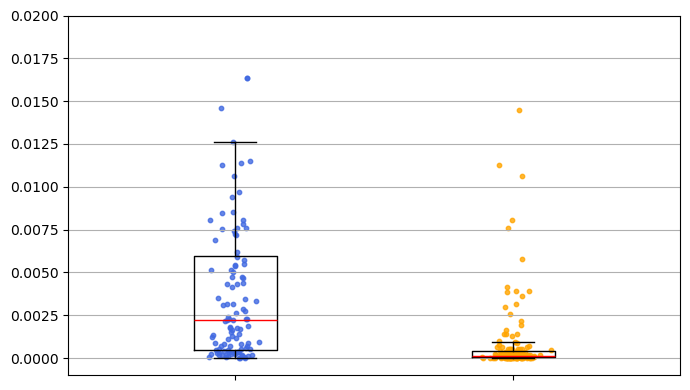

Median value of sum of expression in WGD: 0.002244
Median value of sum of expression in SSD: 0.000128
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5566860465116279, pvalue=6.398801638862186e-20, statistic_location=0.00035407047263674734, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15945.5, pvalue=1.0268611324859104e-20)


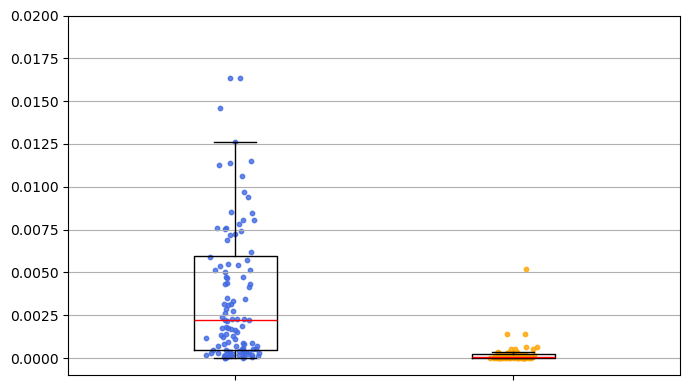

Median value of sum of expression in WGD: 0.002244
Median value of sum of expression in SSD (pre 2R): 6.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.7112341772151899, pvalue=3.8400837519698067e-23, statistic_location=0.00035407047263674734, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8043.0, pvalue=6.765297277288566e-22)


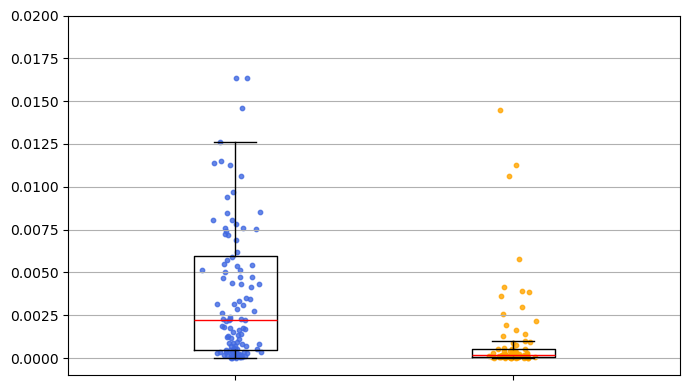

Median value of sum of expression in WGD: 0.002244
Median value of sum of expression in SSD (post 2R): 0.000165
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4876373626373626, pvalue=2.2399596203422054e-11, statistic_location=0.00029125857824053816, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8073.5, pvalue=8.553412628877888e-13)


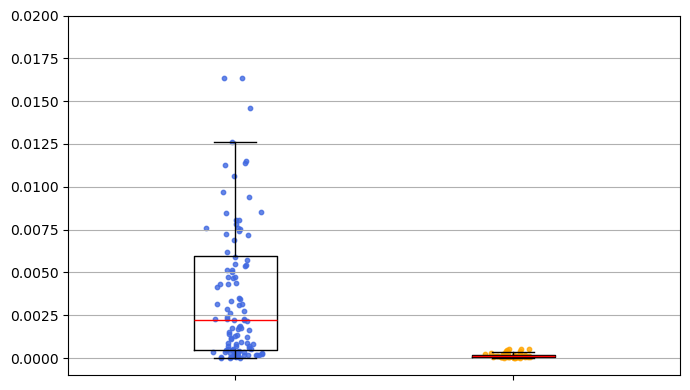

Median value of sum of expression in WGD: 0.002244
Median value of sum of expression in SSD (Mir-430): 0.000105
Kolmogorov-Smirnov test:	KstestResult(statistic=0.7232142857142857, pvalue=1.2587594159482577e-18, statistic_location=0.0005169616044166607, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5328.0, pvalue=1.391006485973611e-17)


In [459]:
label = 'tissue'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Extracellular vescicles (EV)

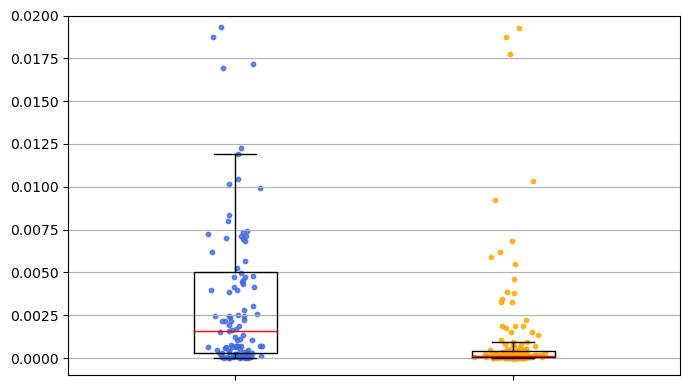

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD: 0.00013
Kolmogorov-Smirnov test:	KstestResult(statistic=0.46615448504983387, pvalue=7.119583823117099e-14, statistic_location=0.0005460485176593643, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=14792.5, pvalue=2.372730159002875e-14)


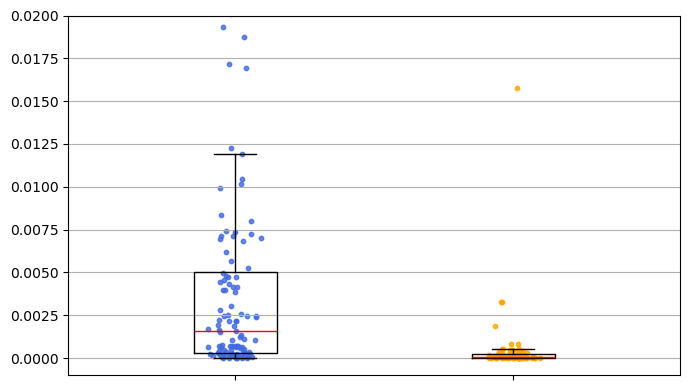

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD (pre 2R): 4.9e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5936934900542495, pvalue=9.202685818245052e-16, statistic_location=0.0005460485176593643, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7536.0, pvalue=1.3430196011014236e-16)


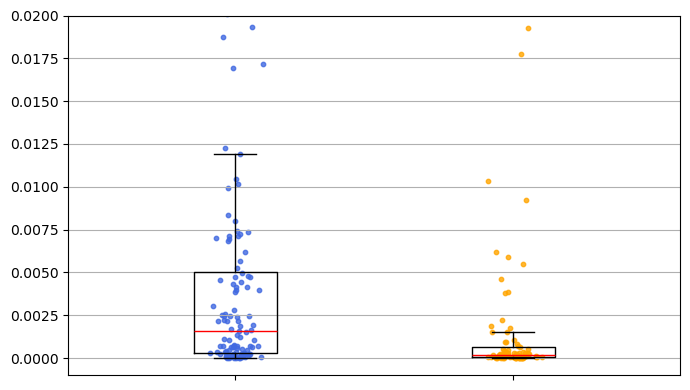

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD (post 2R): 0.000171
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4065934065934066, pvalue=5.862830633466958e-08, statistic_location=0.00037661267217075424, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7351.5, pvalue=6.045850753090908e-08)


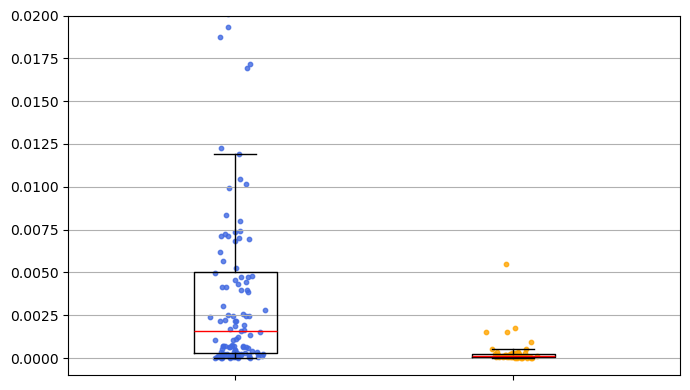

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in Mir-430: 0.00013
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5796703296703297, pvalue=1.251266580819094e-11, statistic_location=0.00037661267217075424, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4750.0, pvalue=8.395287531167284e-11)


In [460]:
label = 'EV'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'Mir-430', f'{label}', -0.001, 0.02)

## Cell lines

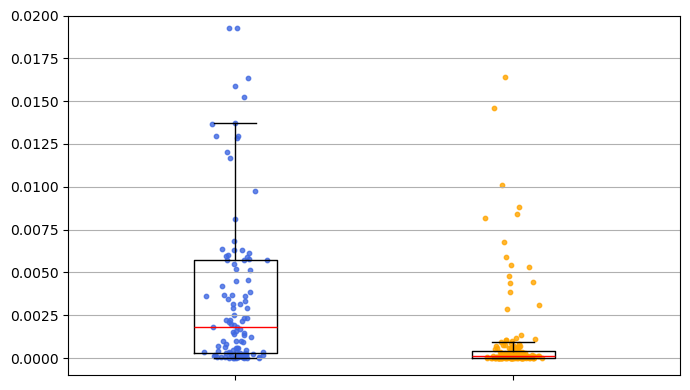

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD: 0.000111
Kolmogorov-Smirnov test:	KstestResult(statistic=0.46179401993355484, pvalue=1.290778467780915e-13, statistic_location=0.0009319293142444639, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=14845.5, pvalue=1.2883021469012327e-14)


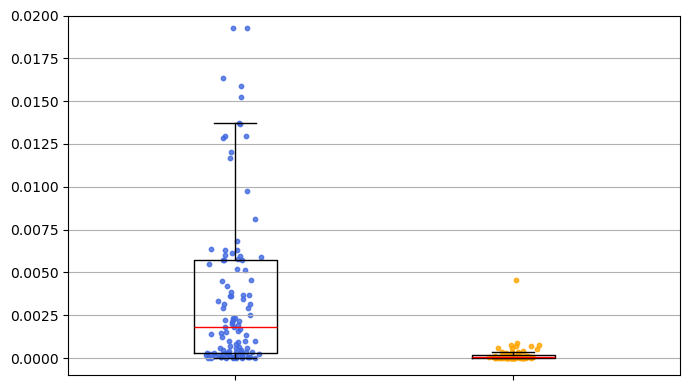

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (pre 2R): 5.2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5950497287522604, pvalue=8.197919408180726e-16, statistic_location=0.00012915705152211207, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7683.0, pvalue=4.701553166253902e-18)


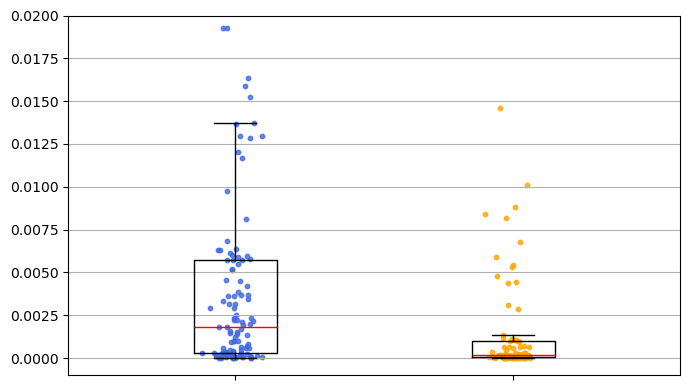

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (post 2R): 0.00018
Kolmogorov-Smirnov test:	KstestResult(statistic=0.38804945054945056, pvalue=2.8306428688117614e-07, statistic_location=0.00022363904012552105, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7180.5, pvalue=5.53920441418062e-07)


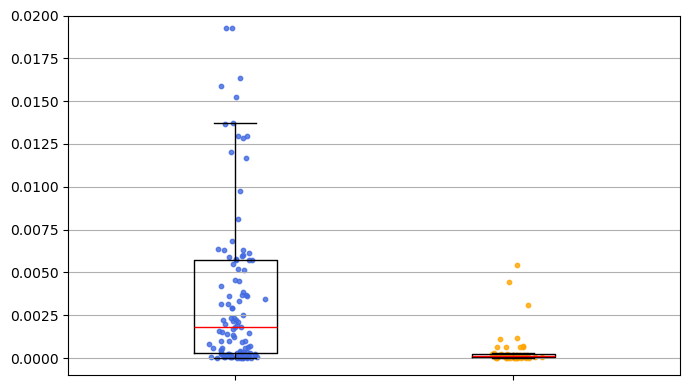

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (Mir-430): 0.000128
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5652472527472527, pvalue=4.8207202108663254e-11, statistic_location=0.00024080599044727047, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4713.0, pvalue=1.983776652433877e-10)


In [461]:
label = 'cell_line'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

_____________________________________

# Tissues

In [462]:
tissues = df_o.columns[df_o.columns.str.startswith('tissue')].tolist()
tissues

['tissue,adipose,adipose,mean',
 'tissue,adrenal_gland,adrenal_gland,mean',
 'tissue,airway,larynx,mean',
 'tissue,airway,pharynx,mean',
 'tissue,aqueous_humor,aqueous_humor,mean',
 'tissue,artery,artery,mean',
 'tissue,bladder,bladder,mean',
 'tissue,blood,PBMC,mean',
 'tissue,blood,blood,mean',
 'tissue,blood,lymphocyte,mean',
 'tissue,blood,plasma,mean',
 'tissue,blood,platelet,mean',
 'tissue,blood,serum,mean',
 'tissue,bone,bone,mean',
 'tissue,bone_marrow,bone_marrow,mean',
 'tissue,bowel,bowel,mean',
 'tissue,bowel,colon,mean',
 'tissue,bowel,duodenum,mean',
 'tissue,bowel,ileum,mean',
 'tissue,bowel,jejunum,mean',
 'tissue,bowel,small_intestine,mean',
 'tissue,brain,arachnoid_mater,mean',
 'tissue,brain,astrocyte,mean',
 'tissue,brain,brain,mean',
 'tissue,brain,cerebellum,mean',
 'tissue,brain,choroid_plexus,mean',
 'tissue,brain,cortex,mean',
 'tissue,brain,dura_matter,mean',
 'tissue,brain,frontal_lobe,mean',
 'tissue,brain,grey_matter,mean',
 'tissue,brain,hippocampus,mean'

## Tissue: Skin

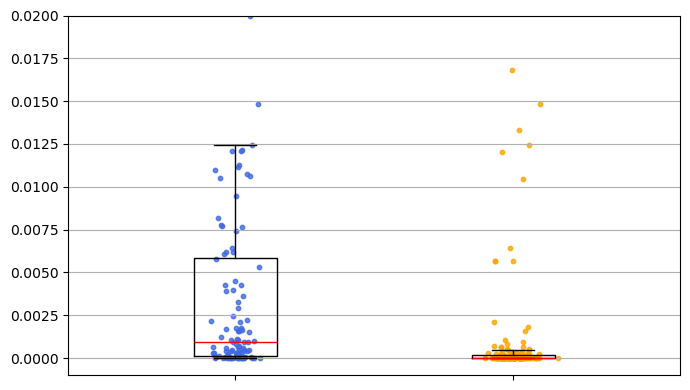

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD: 1.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5045681063122923, pvalue=2.770504834849585e-16, statistic_location=0.0002649836654490298, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15395.5, pvalue=1.594042354116e-17)


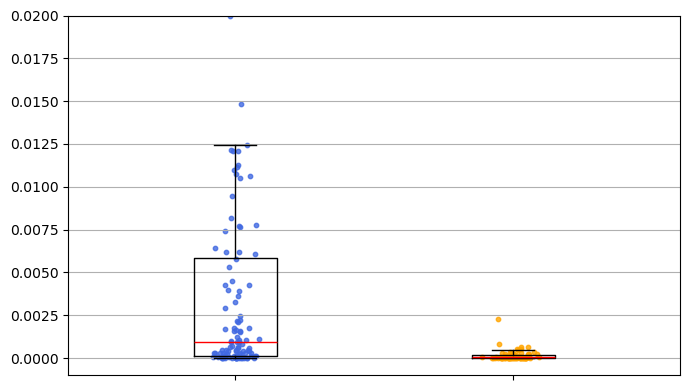

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (pre 2R): 3.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5453209764918626, pvalue=3.111770632659371e-13, statistic_location=0.0003763775536719911, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7205.0, pvalue=1.468634557946872e-13)


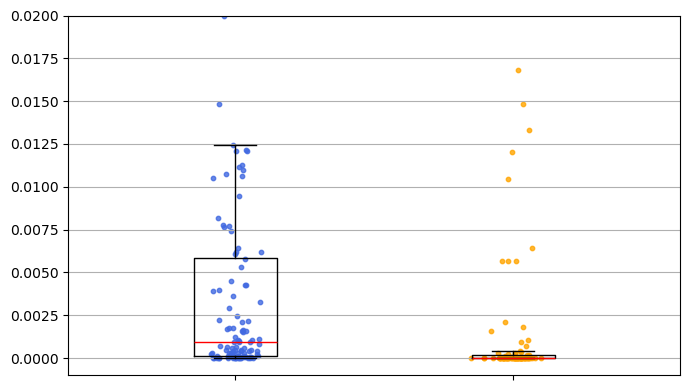

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (post 2R): 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5590659340659341, pvalue=5.245675232267108e-15, statistic_location=1.2312128521052885e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8147.5, pvalue=2.3056531435707986e-13)


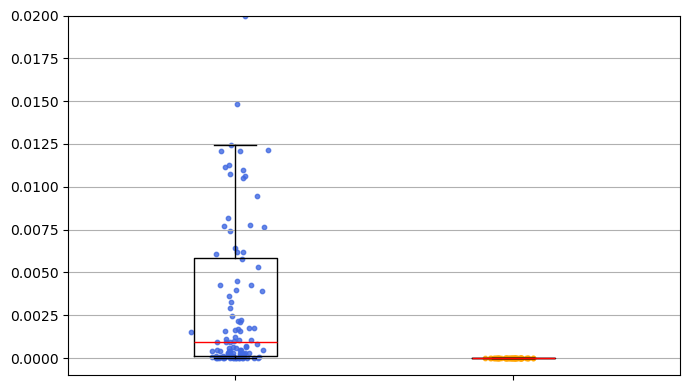

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (Mir-430): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8543956043956044, pvalue=2.032054669646946e-27, statistic_location=1.5236661971657519e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5623.0, pvalue=9.861538435671338e-22)


In [463]:
label = 'tissue,skin'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Connective tissue

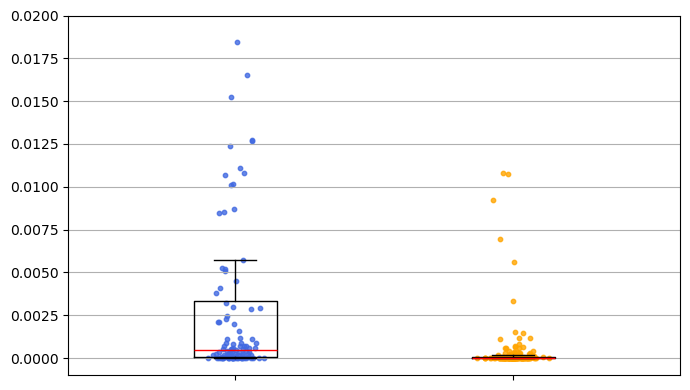

Median value of sum of expression in WGD: 0.000496
Median value of sum of expression in SSD: 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.46677740863787376, pvalue=6.566978674501143e-14, statistic_location=1.917837771572261e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15079.5, pvalue=8.083581144980935e-16)


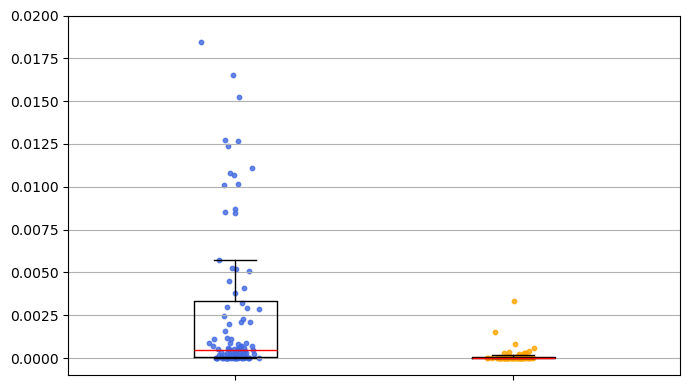

Median value of sum of expression in WGD: 0.000496
Median value of sum of expression in SSD (pre 2R): 1.2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5102848101265823, pvalue=1.4997628152543958e-11, statistic_location=9.637533758887471e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7047.0, pvalue=3.16853704058853e-12)


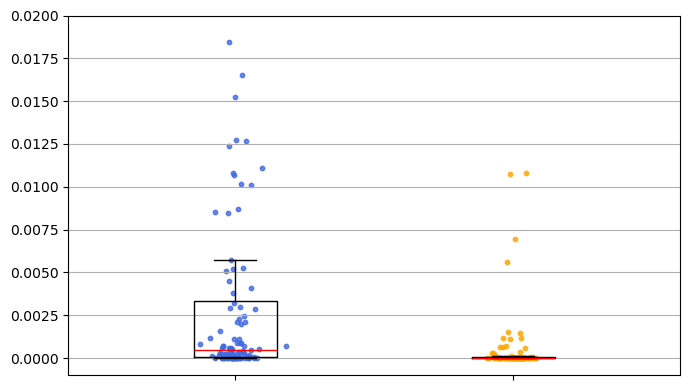

Median value of sum of expression in WGD: 0.000496
Median value of sum of expression in SSD (post 2R): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5467032967032966, pvalue=2.444172214040997e-14, statistic_location=1.654903683773172e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8167.5, pvalue=1.6091653804151038e-13)


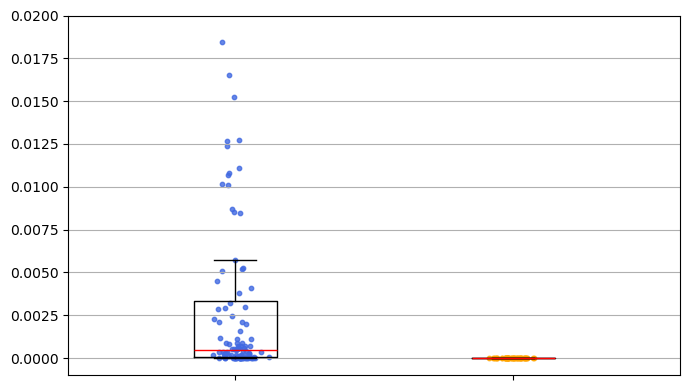

Median value of sum of expression in WGD: 0.000496
Median value of sum of expression in SSD (Mir-430): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8303571428571429, pvalue=1.0551315569957987e-25, statistic_location=1.3121733441461446e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5415.0, pvalue=9.292126807656276e-19)


In [464]:
label = 'tissue,connective_tissue'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Blood

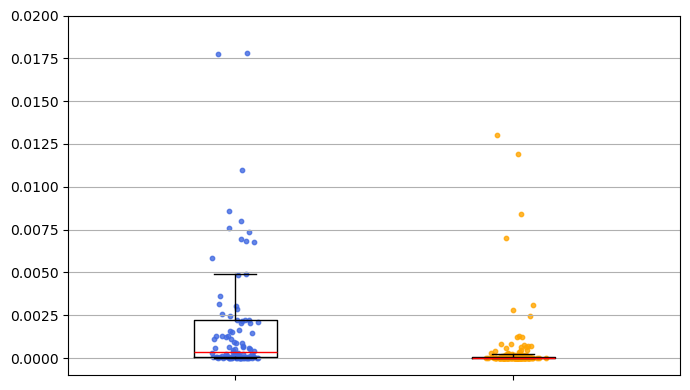

Median value of sum of expression in WGD: 0.000335
Median value of sum of expression in SSD: 1.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.45722591362126247, pvalue=2.399496600174346e-13, statistic_location=1.5842410843198212e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15227.5, pvalue=1.3202407797126359e-16)


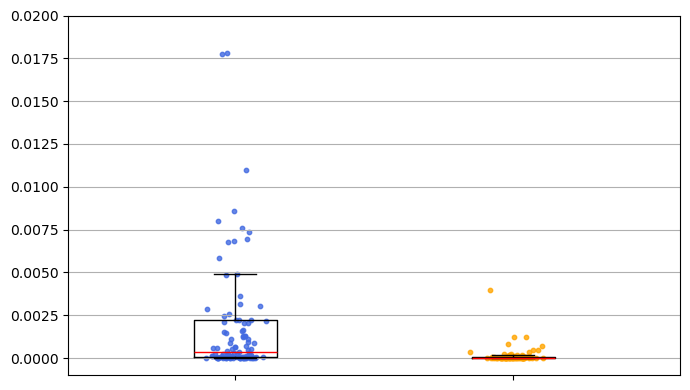

Median value of sum of expression in WGD: 0.000335
Median value of sum of expression in SSD (pre 2R): 2.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.42698915009041594, pvalue=3.8961709757941226e-08, statistic_location=0.0002115413413623555, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7035.0, pvalue=3.9728089286108684e-12)


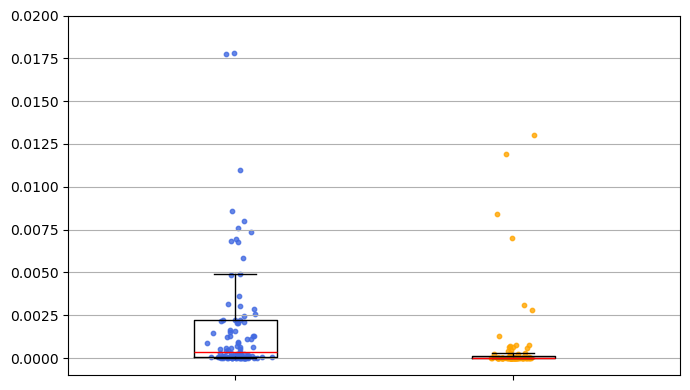

Median value of sum of expression in WGD: 0.000335
Median value of sum of expression in SSD (post 2R): 1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6016483516483516, pvalue=1.7659551784788302e-17, statistic_location=1.1473097575890827e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8201.5, pvalue=8.685786799473763e-14)


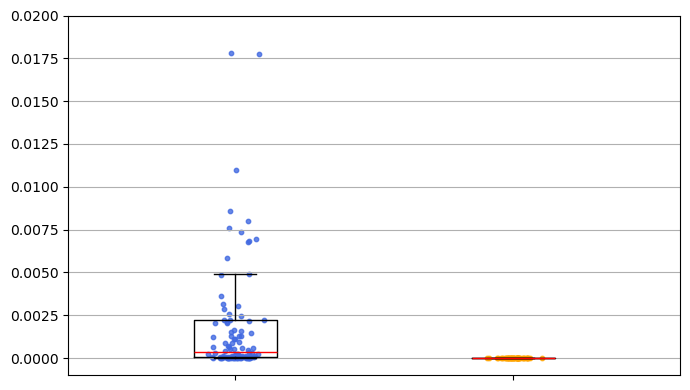

Median value of sum of expression in WGD: 0.000335
Median value of sum of expression in SSD (Mir-430): 7e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8990384615384616, pvalue=3.4782097570742185e-31, statistic_location=1.3623030391393791e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5731.0, pvalue=2.2808258281089496e-23)


In [465]:
label = 'tissue,blood'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Heart

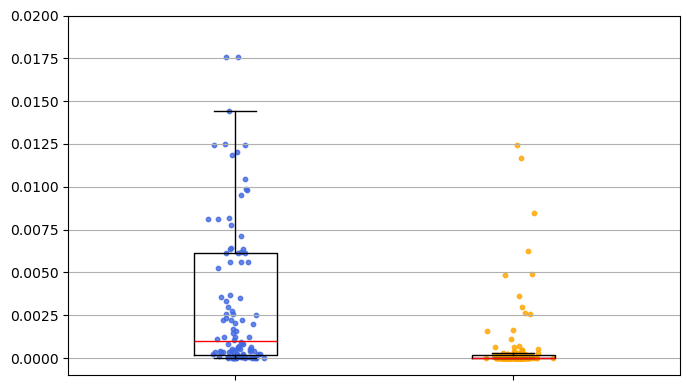

Median value of sum of expression in WGD: 0.001002
Median value of sum of expression in SSD: 8e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5510797342192691, pvalue=1.5987159447192537e-19, statistic_location=0.00030843245952089196, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16010.5, pvalue=4.127019145446704e-21)


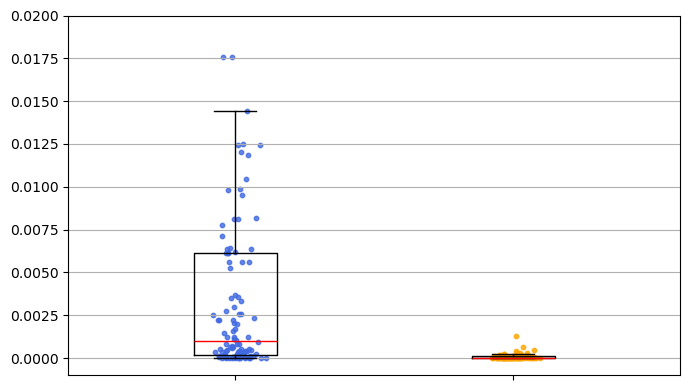

Median value of sum of expression in WGD: 0.001002
Median value of sum of expression in SSD (pre 2R): 1.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6457956600361664, pvalue=8.150629441125162e-19, statistic_location=0.00030376211630366896, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7740.0, pvalue=1.2306090230295531e-18)


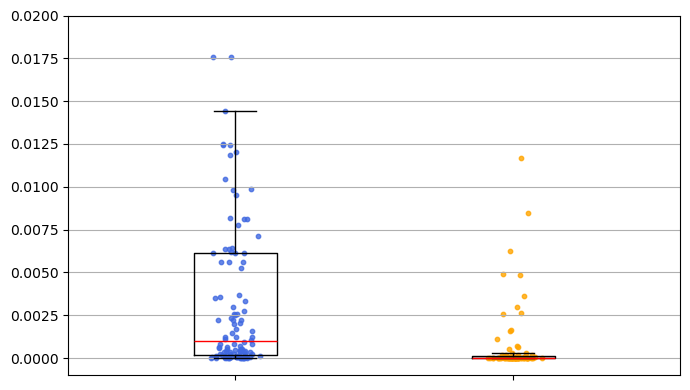

Median value of sum of expression in WGD: 0.001002
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5666208791208791, pvalue=1.9650209470278813e-15, statistic_location=6.214089202576303e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8492.5, pvalue=3.389518894013525e-16)


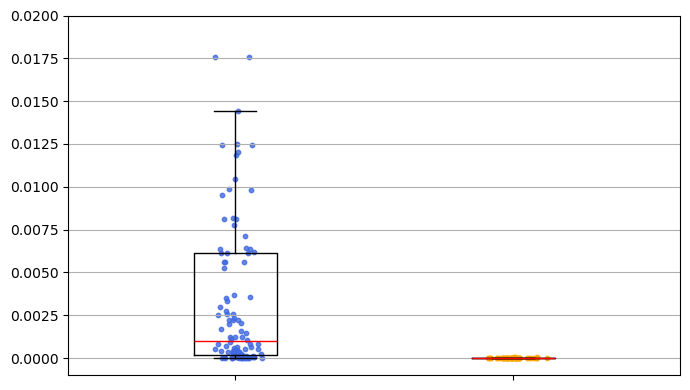

Median value of sum of expression in WGD: 0.001002
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8962912087912088, pvalue=4.138279949465435e-31, statistic_location=4.01375432528716e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5762.0, pvalue=7.533043298425855e-24)


In [466]:
label = 'tissue,heart'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Pancreas

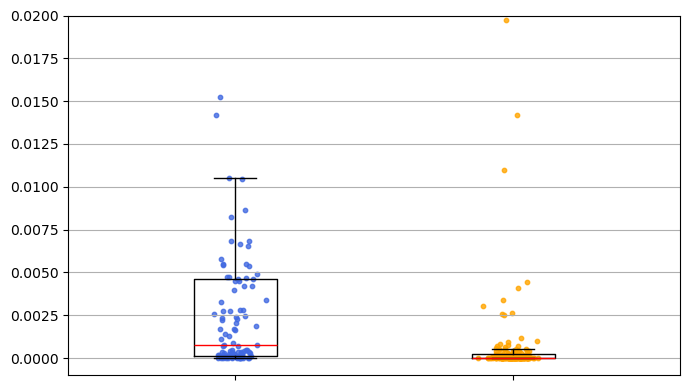

Median value of sum of expression in WGD: 0.000738
Median value of sum of expression in SSD: 1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4684385382059801, pvalue=5.1715566160969084e-14, statistic_location=2.1920212952939605e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15569.5, pvalue=1.6736770787235587e-18)


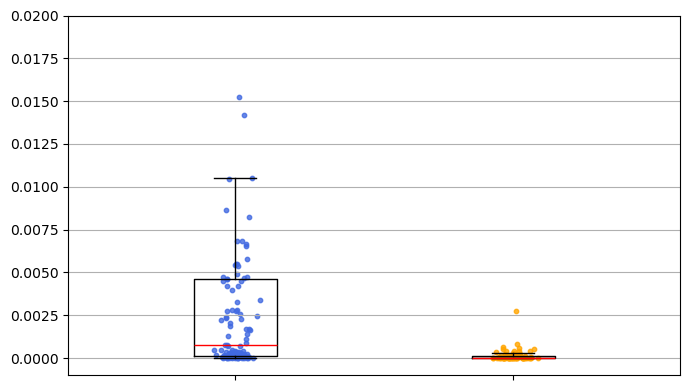

Median value of sum of expression in WGD: 0.000738
Median value of sum of expression in SSD (pre 2R): 2.2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5080244122965641, pvalue=1.928505307062792e-11, statistic_location=0.00013669985938564663, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7380.0, pvalue=3.995143669134061e-15)


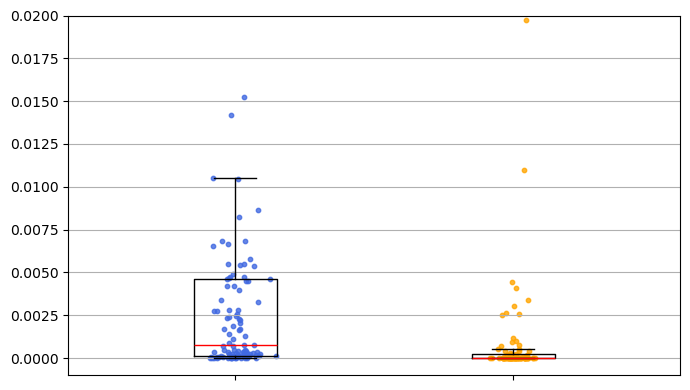

Median value of sum of expression in WGD: 0.000738
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5947802197802198, pvalue=4.620752981937621e-17, statistic_location=7.571844126770718e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8272.5, pvalue=2.346417380854035e-14)


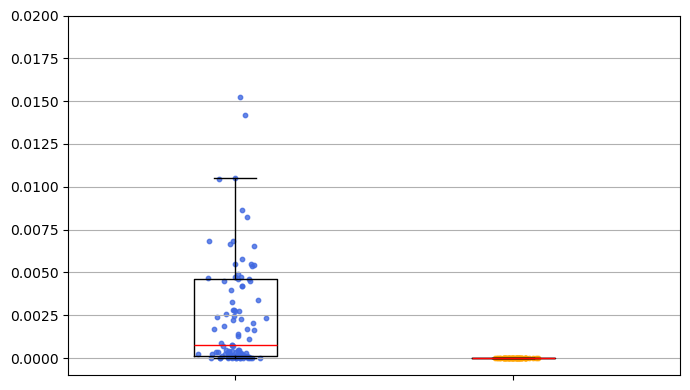

Median value of sum of expression in WGD: 0.000738
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9464285714285714, pvalue=4.206282589547634e-36, statistic_location=2.7380399043724774e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5735.0, pvalue=1.9783448765726858e-23)


In [467]:
label = 'tissue,pancreas'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Testis

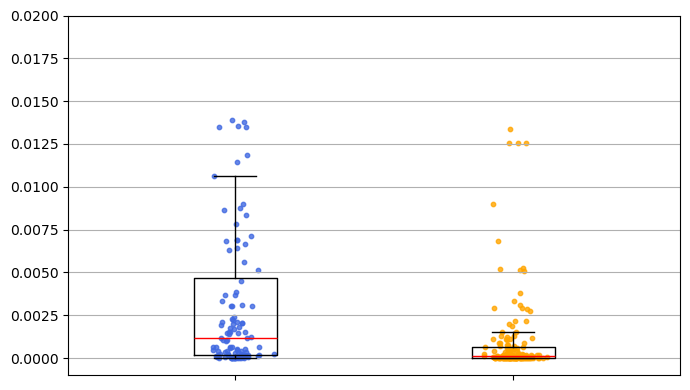

Median value of sum of expression in WGD: 0.001177
Median value of sum of expression in SSD: 0.000114
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4105066445182724, pvalue=8.994222012251626e-11, statistic_location=0.00017734937033330332, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=13784.5, pvalue=8.336674218586988e-10)


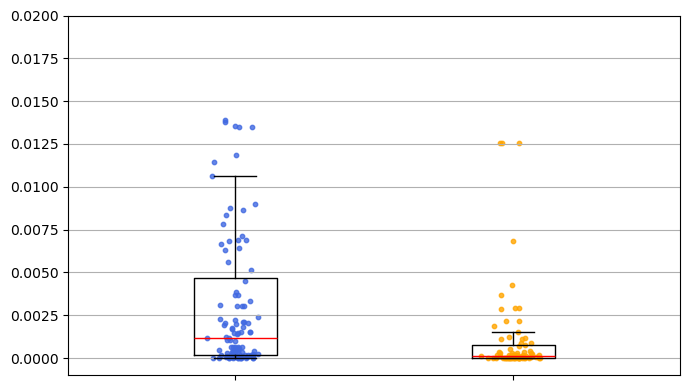

Median value of sum of expression in WGD: 0.001177
Median value of sum of expression in SSD (pre 2R): 0.000129
Kolmogorov-Smirnov test:	KstestResult(statistic=0.3970388788426763, pvalue=4.680624499031755e-07, statistic_location=0.00017734937033330332, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6376.0, pvalue=2.1409261777113162e-07)


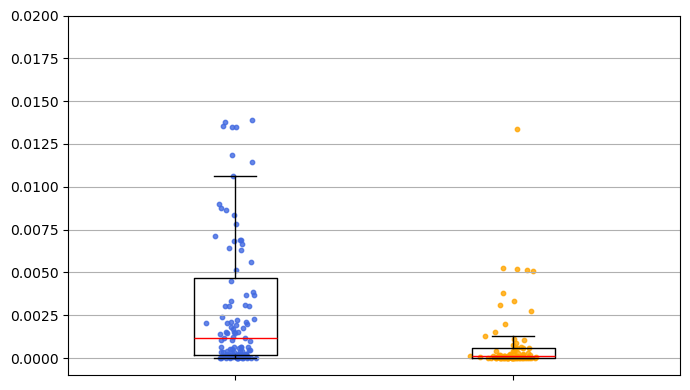

Median value of sum of expression in WGD: 0.001177
Median value of sum of expression in SSD (post 2R): 9.9e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4141483516483517, pvalue=3.015461216678458e-08, statistic_location=0.0001640086076621705, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7340.5, pvalue=7.006151565599738e-08)


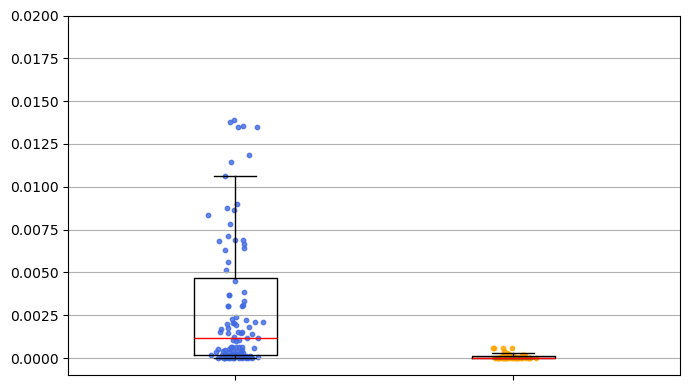

Median value of sum of expression in WGD: 0.001177
Median value of sum of expression in SSD (Mir-430): 2.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6421703296703297, pvalue=2.1828918431733785e-14, statistic_location=0.00016399494120817213, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4945.0, pvalue=6.848251564545964e-13)


In [468]:
label = 'tissue,testis'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Brain

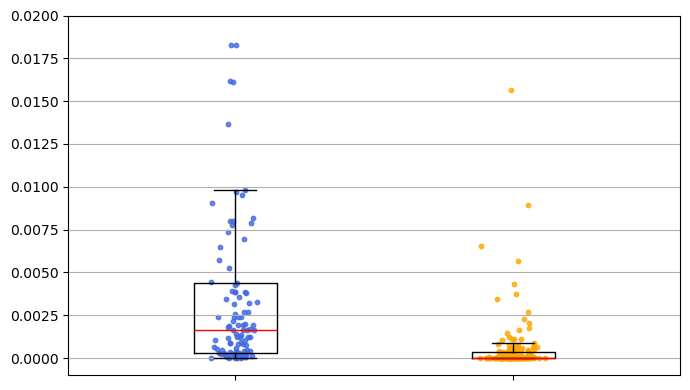

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD: 3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5400747508305648, pvalue=1.025448506471748e-18, statistic_location=0.00018115192375997588, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16132.5, pvalue=7.276034377212407e-22)


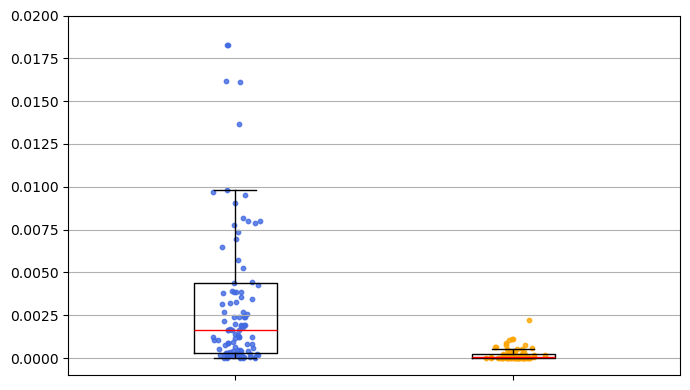

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (pre 2R): 5.1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.588494575045208, pvalue=1.7587051614209718e-15, statistic_location=0.000763825317535274, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7733.0, pvalue=1.4525765303886144e-18)


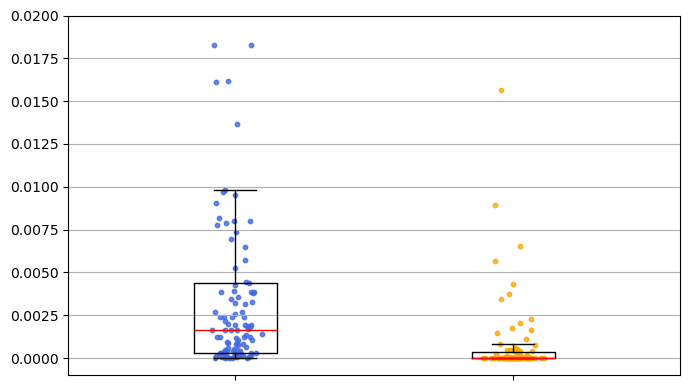

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (post 2R): 1.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6009615384615384, pvalue=1.977435452539591e-17, statistic_location=7.894819415906073e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8496.5, pvalue=3.130198380369675e-16)


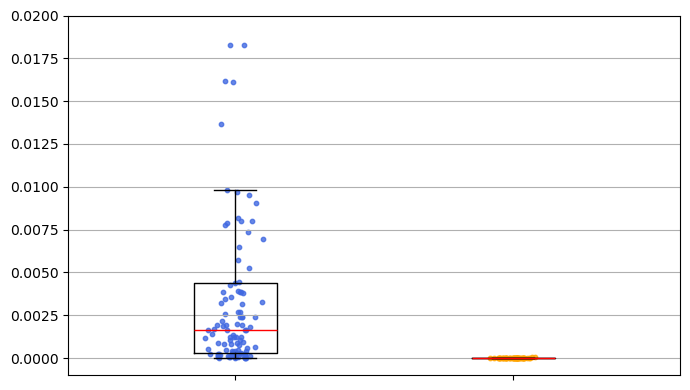

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (Mir-430): 7e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9258241758241759, pvalue=7.883393497722423e-34, statistic_location=2.143998885034681e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5734.0, pvalue=2.0500176028281957e-23)


In [469]:
label = 'tissue,brain'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

_________________

## Cell lines

In [470]:
cl = df_o.columns[df_o.columns.str.startswith('cell_line')].tolist()
cl

['cell_line,NCI_60_cancer_panel,NCI_60_cancer_panel,mean',
 'cell_line,adipose,adipose,mean',
 'cell_line,airway,HS840,mean',
 'cell_line,airway,epithelium,mean',
 'cell_line,airway,pharynx,mean',
 'cell_line,artery,artery,mean',
 'cell_line,ascites,AD3,mean',
 'cell_line,bladder,bladder,mean',
 'cell_line,blood,MEC1,mean',
 'cell_line,blood,Molm14,mean',
 'cell_line,blood,THP,mean',
 'cell_line,blood,blood,mean',
 'cell_line,blood,plasma,mean',
 'cell_line,blood,serum,mean',
 'cell_line,bone,143B,mean',
 'cell_line,bone,HFO,mean',
 'cell_line,bone,U2OS,mean',
 'cell_line,bone,bone,mean',
 'cell_line,bone_marrow,BL_cell_line,mean',
 'cell_line,bone_marrow,BMSC,mean',
 'cell_line,bone_marrow,HAP1,mean',
 'cell_line,bone_marrow,K562,mean',
 'cell_line,bone_marrow,SHSY5Y,mean',
 'cell_line,bowel,Caco,mean',
 'cell_line,bowel,HCT116,mean',
 'cell_line,bowel,HT29,mean',
 'cell_line,bowel,PEO1,mean',
 'cell_line,bowel,colon,mean',
 'cell_line,brain,HOG,mean',
 'cell_line,brain,NCH421k,mean',

## Cell line: Blood

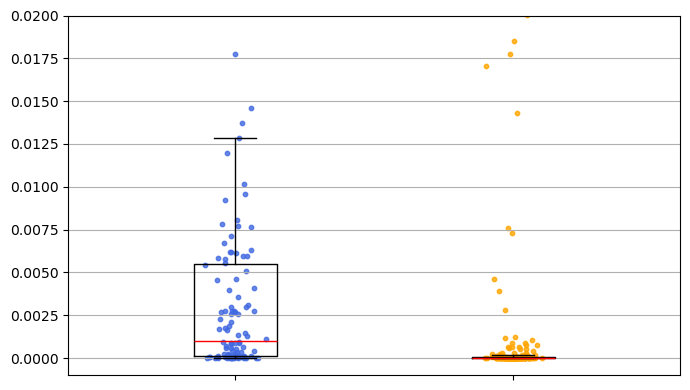

Median value of sum of expression in WGD: 0.001022
Median value of sum of expression in SSD: 4e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5859634551495017, pvalue=3.465630600512074e-22, statistic_location=1.5609337625855187e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16190.5, pvalue=3.1524937151431263e-22)


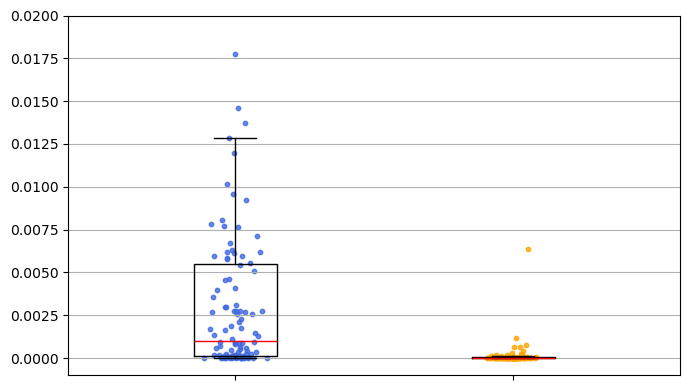

Median value of sum of expression in WGD: 0.001022
Median value of sum of expression in SSD (pre 2R): 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6077079566003617, pvalue=1.598571580892203e-16, statistic_location=5.1730793963476454e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7865.0, pvalue=6.012502513967144e-20)


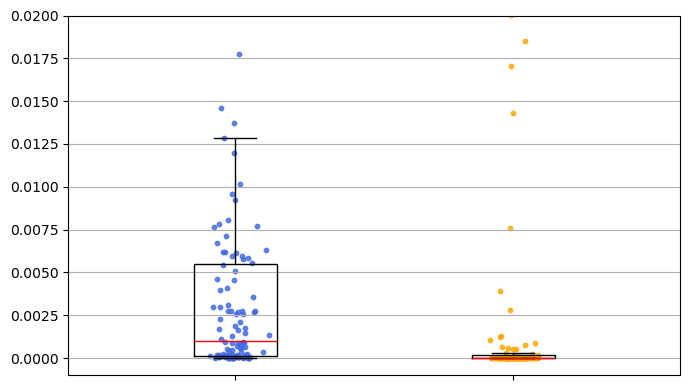

Median value of sum of expression in WGD: 0.001022
Median value of sum of expression in SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6497252747252747, pvalue=1.492237747076417e-20, statistic_location=1.5609337625855187e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8405.5, pvalue=1.8714135764835156e-15)


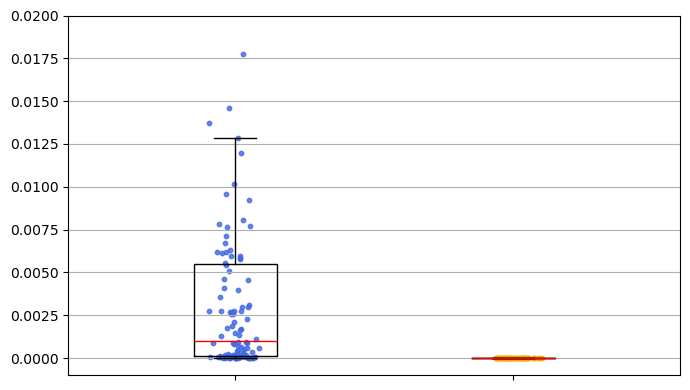

Median value of sum of expression in WGD: 0.001022
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9539835164835165, pvalue=6.6346309489781045e-37, statistic_location=6.128156928423849e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5759.0, pvalue=8.389889956305892e-24)


In [471]:
label = 'cell_line,blood'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Liver

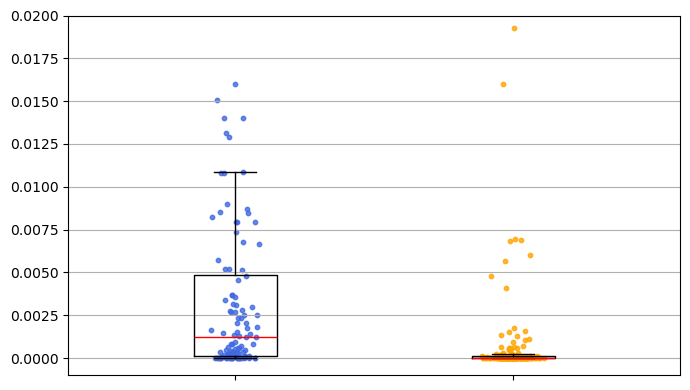

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD: 3e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5213870431893688, pvalue=2.1048356618022022e-17, statistic_location=5.079465868618367e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15747.5, pvalue=1.5594181948185088e-19)


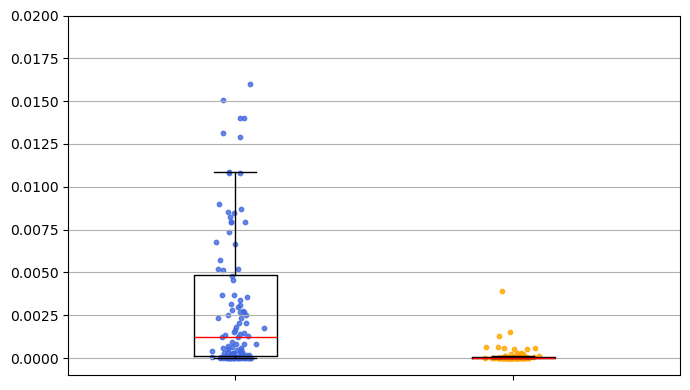

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (pre 2R): 6e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5430605786618445, pvalue=4.1173805534310436e-13, statistic_location=0.0002678088384552848, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7462.0, pvalue=6.858085114755901e-16)


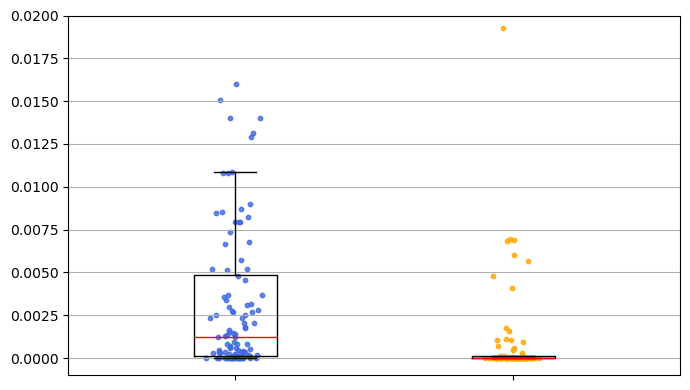

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5741758241758241, pvalue=7.437737268300351e-16, statistic_location=9.759957035644216e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8174.5, pvalue=1.4180779412166927e-13)


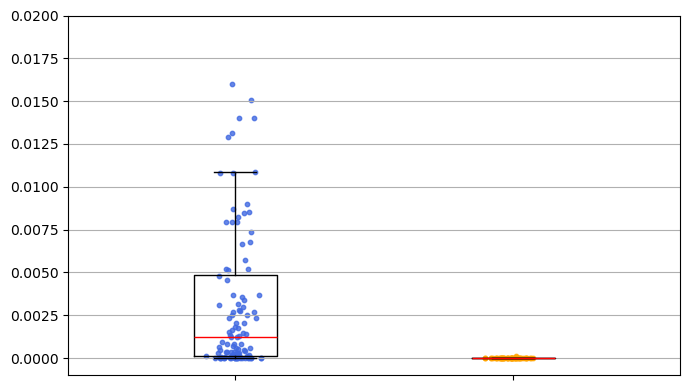

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.915521978021978, pvalue=7.005479907454228e-33, statistic_location=1.1833863877008493e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5691.0, pvalue=9.359800199174955e-23)


In [472]:
label = 'cell_line,liver'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Nerve

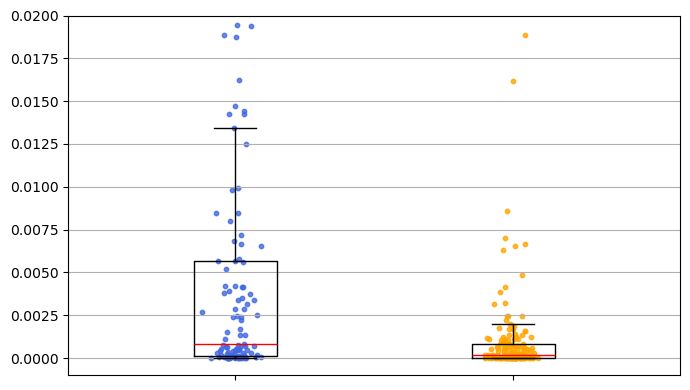

Median value of sum of expression in WGD: 0.00081
Median value of sum of expression in SSD: 0.000172
Kolmogorov-Smirnov test:	KstestResult(statistic=0.34177740863787376, pvalue=1.5018508735324087e-07, statistic_location=0.0021991959124524024, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=13068.5, pvalue=3.7776182309279014e-07)


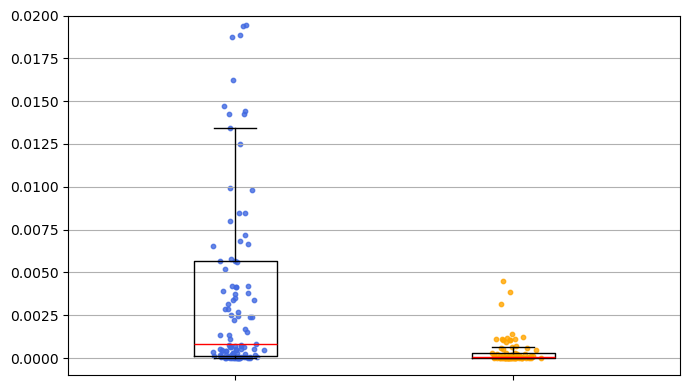

Median value of sum of expression in WGD: 0.00081
Median value of sum of expression in SSD (pre 2R): 7.4e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.43806509945750455, pvalue=1.551252639753838e-08, statistic_location=0.00028559643450716955, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6802.0, pvalue=2.6346294574958934e-10)


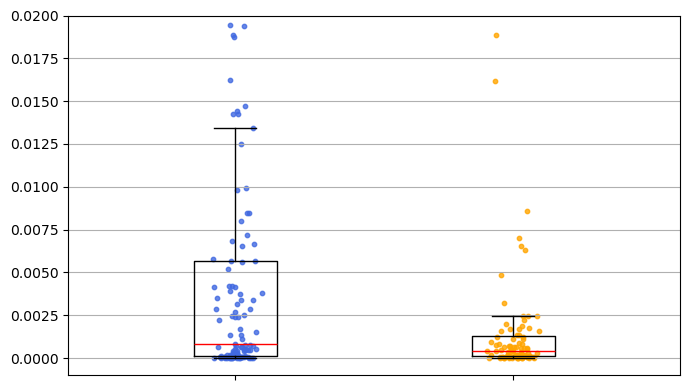

Median value of sum of expression in WGD: 0.00081
Median value of sum of expression in SSD (post 2R): 0.000431
Kolmogorov-Smirnov test:	KstestResult(statistic=0.30357142857142855, pvalue=0.0001348369824494236, statistic_location=0.0021991959124524024, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6317.5, pvalue=0.0033533057425818528)


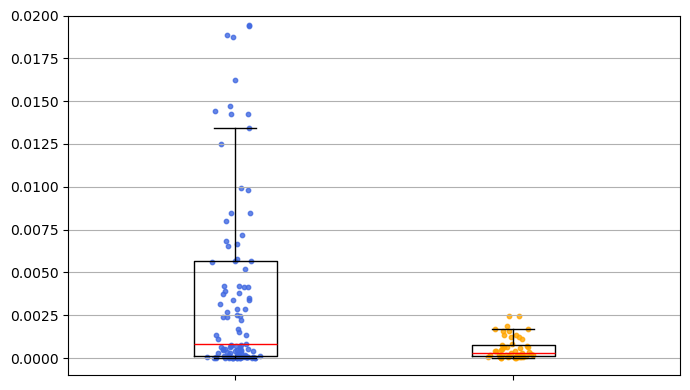

Median value of sum of expression in WGD: 0.00081
Median value of sum of expression in SSD (Mir-430): 0.000302
Kolmogorov-Smirnov test:	KstestResult(statistic=0.41964285714285715, pvalue=3.8010476446921603e-06, statistic_location=0.002433607332431809, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3805.0, pvalue=0.0016109935952564327)


In [473]:
label = 'cell_line,nerve'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Stem cells

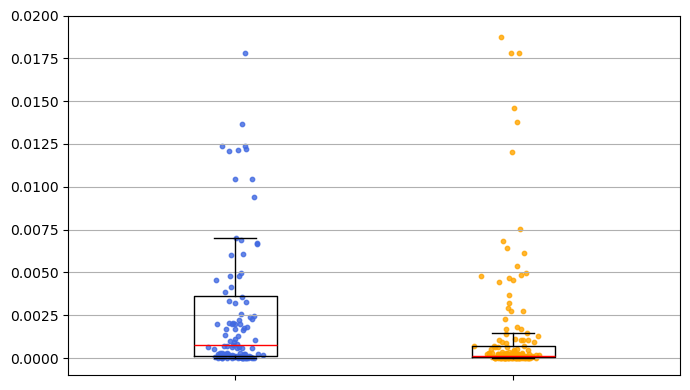

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD: 0.000122
Kolmogorov-Smirnov test:	KstestResult(statistic=0.30398671096345514, pvalue=4.749026598744117e-06, statistic_location=0.0005460029360705884, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12738.5, pvalue=4.3910590043198194e-06)


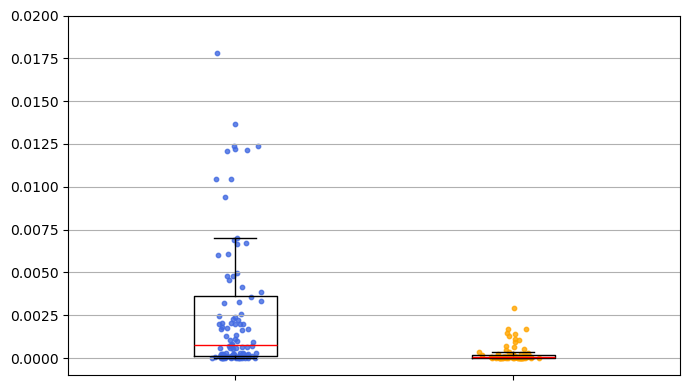

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (pre 2R): 6.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4559222423146474, pvalue=3.1435825251623454e-09, statistic_location=0.00015902801123262865, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6844.0, pvalue=1.2717770126529955e-10)


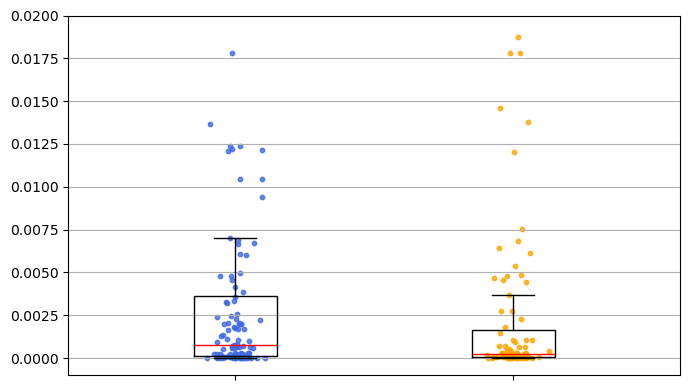

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (post 2R): 0.000218
Kolmogorov-Smirnov test:	KstestResult(statistic=0.21978021978021978, pvalue=0.0128759950063817, statistic_location=0.0005378552379762261, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5996.5, pvalue=0.030604991678435695)


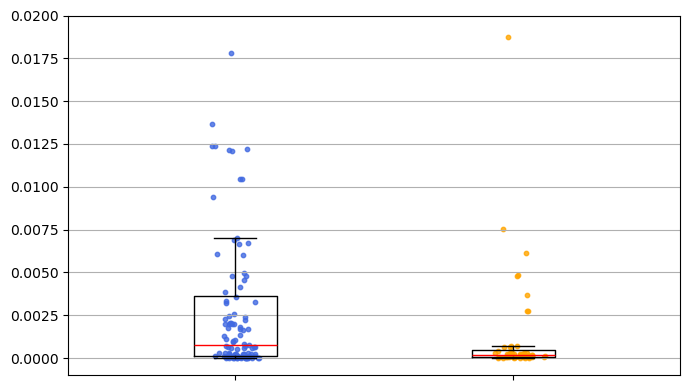

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (Mir-430): 0.000189
Kolmogorov-Smirnov test:	KstestResult(statistic=0.33035714285714285, pvalue=0.000595806108770099, statistic_location=0.0004315771129077668, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3687.0, pvalue=0.006201708690110082)


In [474]:
label = 'cell_line,stem_cells'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Lung

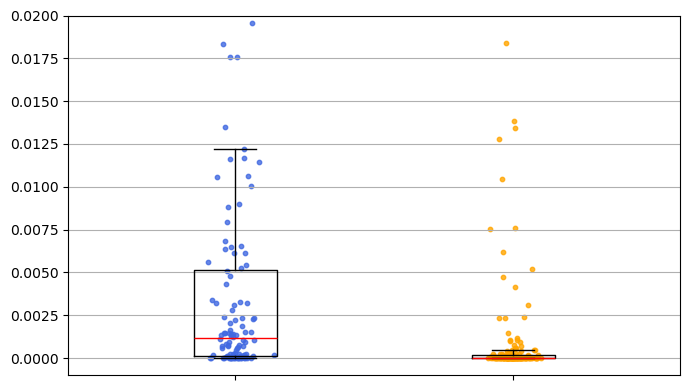

Median value of sum of expression in WGD: 0.001154
Median value of sum of expression in SSD: 1.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.47093023255813954, pvalue=3.738884283726148e-14, statistic_location=0.00012554925019246218, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15096.5, pvalue=6.580412478592992e-16)


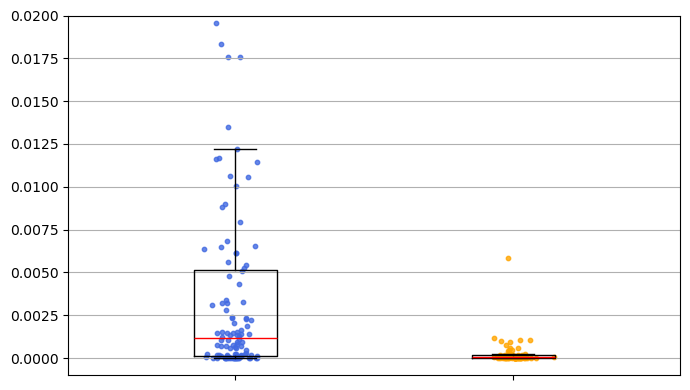

Median value of sum of expression in WGD: 0.001154
Median value of sum of expression in SSD (pre 2R): 5.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5185352622061483, pvalue=5.982445996943511e-12, statistic_location=0.0005917032607014355, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7100.0, pvalue=1.152875640808902e-12)


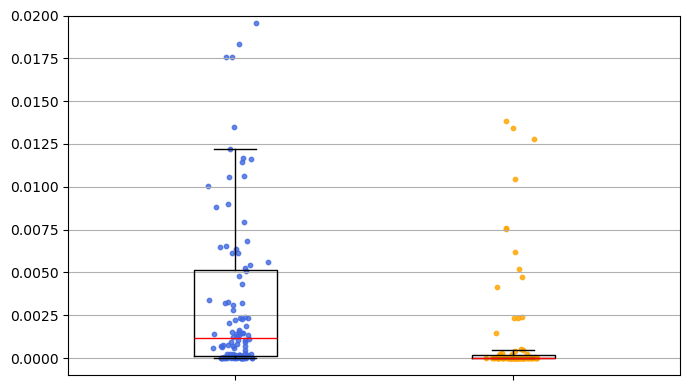

Median value of sum of expression in WGD: 0.001154
Median value of sum of expression in SSD (post 2R): 3e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.521978021978022, pvalue=4.777498042447805e-13, statistic_location=6.244868723123279e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7957.5, pvalue=6.273272538313698e-12)


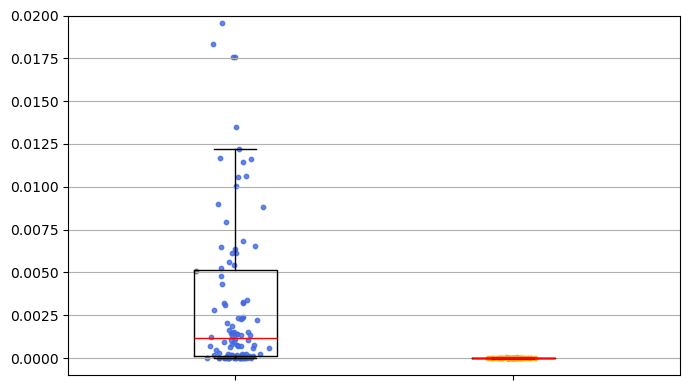

Median value of sum of expression in WGD: 0.001154
Median value of sum of expression in SSD (Mir-430): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8008241758241759, pvalue=1.570344044687024e-23, statistic_location=2.4413772835864394e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5488.0, pvalue=8.927340049687733e-20)


In [475]:
label = 'cell_line,lung'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)